In [1]:
%matplotlib inline
import keras.backend as K

Using TensorFlow backend.


## Tell Tensorflow to use no more GPU RAM than necessary

In [2]:
K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

## prepare files

In [3]:
import glob
from PIL import Image
import numpy as np

In [4]:
fnames = glob.glob('train/*/*.JPEG', recursive=True)
len(fnames)

19439

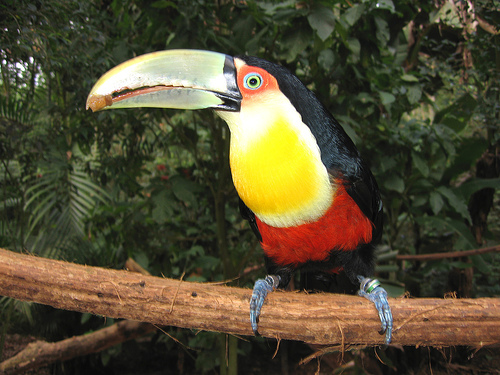

In [5]:
img = Image.open(fnames[100]); img

In [6]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [7]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [8]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape
shp

(1, 375, 500, 3)

## recreate input with vgg16 (avg pooling)

In [9]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, AveragePooling2D
from keras.applications.imagenet_utils import _obtain_input_shape

In [10]:
K.set_image_dim_ordering('tf')
input_shape = (375, 500, 3)
input_shape

(375, 500, 3)

In [11]:
img_input = Input(shape=input_shape)
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

inputs = img_input
model = Model(inputs, x, name='vgg16')
model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 375, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 375, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 375, 500, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 187, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 187, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 187, 250, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 93, 125, 128)      0         
__________

In [12]:
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [13]:
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt

In [14]:
#loss = metrics.mse(layer, targ)
loss = K.mean(metrics.mse(layer, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
loss, layer, targ

(<tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 23, 31, 512) dtype=float32>,
 <tf.Variable 'Variable:0' shape=(1, 23, 31, 512) dtype=float32_ref>)

In [15]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
evaluator = Evaluator(fn, shp)

In [16]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        #print(x.shape, min_val.shape)
        imsave(f'results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

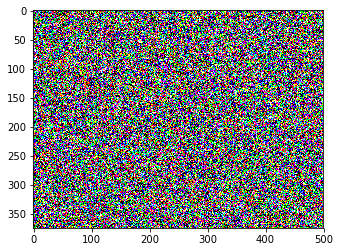

In [17]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [18]:
iterations=10
x = solve_image(evaluator, iterations, x)

Current loss value: 80.9446334839
Current loss value: 29.5215110779
Current loss value: 17.6245040894
Current loss value: 12.4419498444
Current loss value: 9.64943981171
Current loss value: 8.06110572815
Current loss value: 6.96158218384
Current loss value: 6.23454904556
Current loss value: 5.69796609879
Current loss value: 5.26409769058


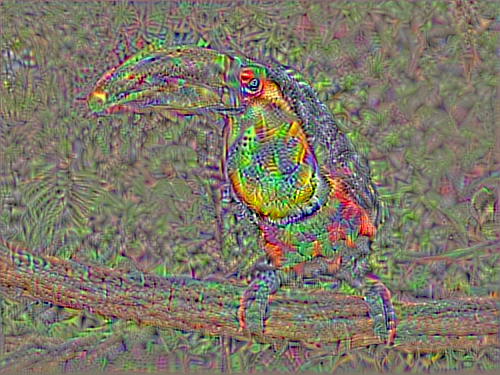

In [19]:
Image.open('results/res_at_iteration_1.png')

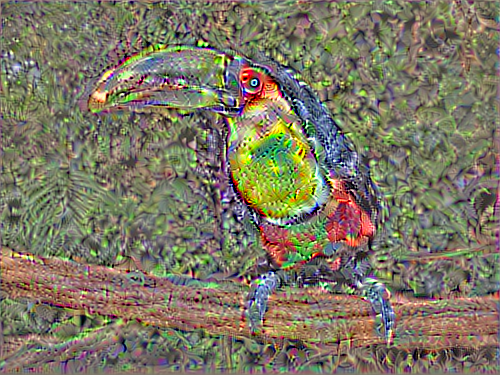

In [20]:
Image.open('results/res_at_iteration_9.png')

RuntimeError: No MovieWriters available!

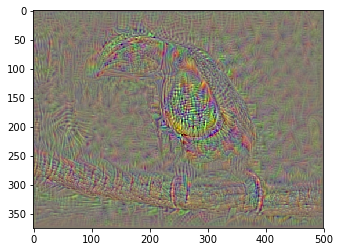

In [21]:
from IPython.display import HTML
from matplotlib import animation, rc
fig, ax = plt.subplots()
def animate(i):
    ax.imshow(Image.open(f'results/res_at_iteration_{i}.png'))
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

No MovieWriters available http://forums.fast.ai/t/runtimeerror-no-moviewriters-available/1888

## recreate style

In [22]:
def plot_arr(arr):
    plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

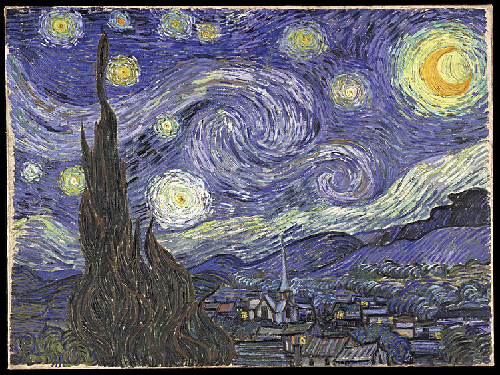

In [23]:
style = Image.open('starry_night.jpg')
style = style.resize((500, 375)); style

In [24]:
style_arr = preproc(np.expand_dims(style,0))
shp = style_arr.shape

In [25]:
outputs = {l.name: l.output for l in model.layers}
outputs

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 375, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 375, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/AvgPool:0' shape=(?, 187, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 187, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 187, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/AvgPool:0' shape=(?, 93, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 93, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 93, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 93, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/AvgPool:0' shape=(?, 46, 62, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 46, 62, 512) dtype=float32>,
 'block

In [26]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1, 3)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [27]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [28]:
def style_loss(x, targ):
    #return metrics.mse(gram_matrix(x), gram_matrix(targ))
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [29]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [30]:
import scipy

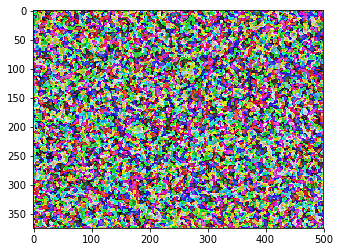

In [31]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
plt.imshow(x[0])

In [32]:
x = solve_image(evaluator, 10, x)

Current loss value: 1295.23608398
Current loss value: 218.991424561
Current loss value: 105.505203247
Current loss value: 66.3377456665
Current loss value: 48.0885620117
Current loss value: 34.6247062683
Current loss value: 26.1624031067
Current loss value: 20.1294269562
Current loss value: 15.2545909882
Current loss value: 12.4261045456


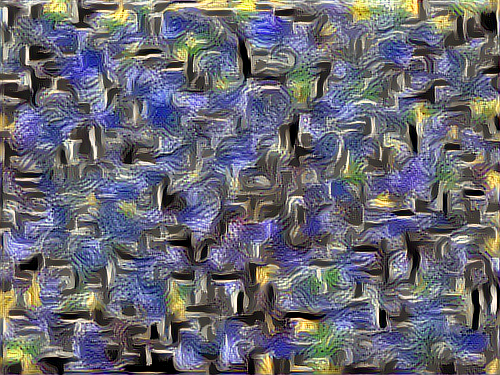

In [33]:
Image.open('results/res_at_iteration_9.png')

## transfer style

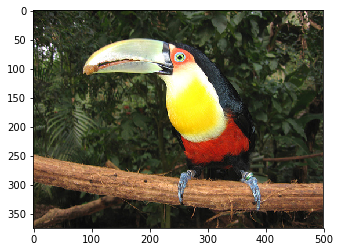

In [34]:
w, h = style.size
src = img_arr[:, :h, :w]
plot_arr(src)

In [35]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [36]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [37]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [38]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [39]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += K.mean(metrics.mse(content_layer, content_targ)/10)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [40]:
evaluator = Evaluator(transfer_fn, shp)

In [41]:
x = rand_img(shp)
x = solve_image(evaluator, iterations, x)

Current loss value: 4995.29541016
Current loss value: 1125.19775391
Current loss value: 644.222106934
Current loss value: 528.365356445
Current loss value: 453.455322266
Current loss value: 403.033935547
Current loss value: 366.7394104
Current loss value: 337.43145752
Current loss value: 312.96887207
Current loss value: 294.681335449


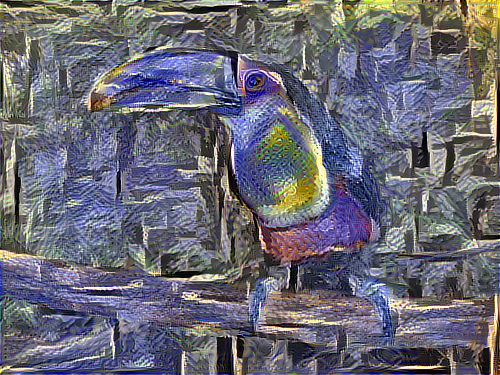

In [42]:
Image.open('results/res_at_iteration_9.png')

additional things https://github.com/titu1994/Neural-Style-Transfer

## Using Fully Convolutional Network

In [85]:
import bcolz
from keras_tqdm import TQDMNotebookCallback
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers.merge import add
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.layers.pooling import MaxPooling2D

progress bars https://github.com/bstriner/keras-tqdm

In [45]:
arr_lr = bcolz.open('trn_resized_72.bc')[:]
arr_hr = bcolz.open('trn_resized_288.bc')[:]

https://github.com/tqdm/tqdm/issues/360

In [95]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

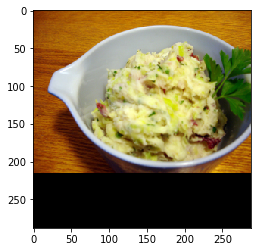

In [48]:
plt.imshow(arr_hr[10].astype('uint8'));

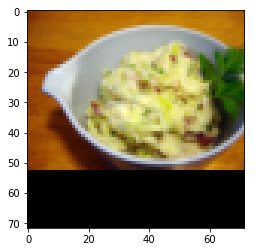

In [54]:
plt.imshow(arr_lr[10].astype('uint8'));

In [65]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, (size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [70]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return add([x, ip])

In [74]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Conv2DTranspose(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [73]:
def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [77]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Conv2D(3, (9, 9), activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [96]:
vgg_inp = Input(arr_hr.shape[1:])
img_input = Lambda(preproc)(vgg_inp)

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

vgg = Model(vgg_inp, x, name='vgg16')
vgg.summary()
vgg.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [97]:
for l in vgg.layers: l.trainable=False

In [98]:
def get_outp(m, ln):
    return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [91]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [92]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [99]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

In [101]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, verbose=1)

Epoch 1/2
19439/19439 [==============================] - 2550s - loss: 20512.2153  
Epoch 2/2
19439/19439 [==============================] - 2555s - loss: 19724.1064  


In [102]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, verbose=1)

Epoch 1/1
19439/19439 [==============================] - 2185s - loss: 18412.7420  


In [103]:
top_model = Model(inp, outp)

In [105]:
p = top_model.predict(arr_lr[10:11])

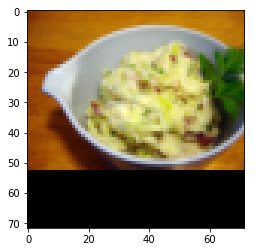

In [106]:
plt.imshow(arr_lr[10].astype('uint8'));

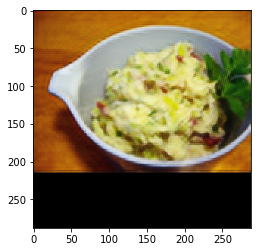

In [107]:
plt.imshow(p[0].astype('uint8'));

In [108]:
top_model.save_weights('sr_final.h5')

In [111]:
top_model.load_weights('sr_final.h5')

TODO: Validation set

## Fast Style Transfer
use the super resolution approach

### reflection padding
https://keras.io/layers/writing-your-own-keras-layers/

In [118]:
from keras.engine.topology import Layer, InputSpec
import tensorflow as tf

In [197]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
    
    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[1], s[2] + 2 * self.padding[0], s[3])
        
    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [198]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,10))(inp))
ref_model.compile('adam', 'mse')

In [199]:
ref_model.summary()
p[0].shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 288, 288, 3)       0         
_________________________________________________________________
reflection_padding2d_12 (Ref (None, 308, 368, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


(308, 368, 3)

In [155]:
p = ref_model.predict(arr_hr[10:11])
p[0].shape, p[0][288, 288], arr_hr[10][287, 287]

((308, 368, 3),
 array([ 0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32))

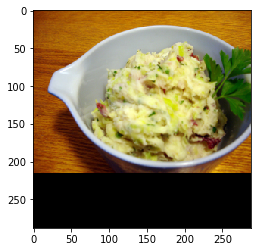

In [156]:
plt.imshow(arr_hr[10].astype('uint8'));

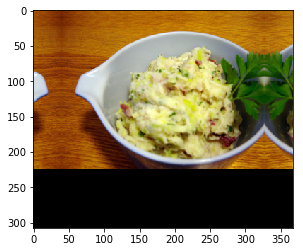

In [152]:
plt.imshow(p[0].astype('uint8'));

### main algorithm

In [157]:
shp = arr_hr.shape[1:]

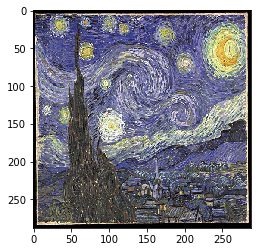

In [158]:
style = Image.open('starry_night.jpg')
style = style.resize((288, 288))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [161]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return add([x, ip])

In [202]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Conv2D(3, (9, 9), activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [203]:
z = Model(inp, outp)
z.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_30 (InputLayer)            (None, 288, 288, 3)   0                                            
____________________________________________________________________________________________________
reflection_padding2d_14 (Reflect (None, 368, 368, 3)   0           input_30[0][0]                   
____________________________________________________________________________________________________
conv2d_92 (Conv2D)               (None, 368, 368, 64)  15616       reflection_padding2d_14[0][0]    
____________________________________________________________________________________________________
batch_normalization_86 (BatchNor (None, 368, 368, 64)  256         conv2d_92[0][0]                  
___________________________________________________________________________________________

In [204]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [205]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [206]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [207]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [209]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [210]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [213]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 8, 2, verbose=1)

Epoch 1/2
19439/19439 [==============================] - 4760s - loss: 552.5819  
Epoch 2/2
19439/19439 [==============================] - 4757s - loss: 480.1848  


In [214]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 1, verbose=1)

Epoch 1/1
19439/19439 [==============================] - 4197s - loss: 456.8531  


In [215]:
top_model = Model(inp, outp)

In [216]:
p = top_model.predict(arr_hr[:20])

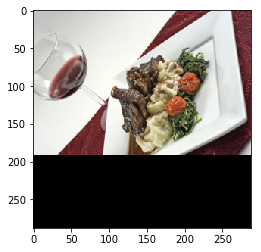

In [230]:
plt.imshow(arr_hr[9].astype('uint8'));

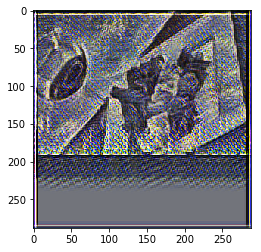

In [231]:
plt.imshow(np.round(p[9]).astype('uint8'));

In [218]:
top_model.save_weights('style_final.h5')

In [219]:
top_model.load_weights('style_final.h5')

### Next steps
Here's some ideas for things to try:
* https://github.com/junyanz/iGAN
* https://arxiv.org/abs/1605.04603
* https://arxiv.org/abs/1606.05897
* http://cs231n.stanford.edu/reports2016/208_Report.pdf